In [1]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay

# Preprocessing

In [2]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [3]:
train.shape

(165034, 11)

In [4]:
X = train.drop(columns='Exited')
y = train.Exited

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.15)

In [6]:
prepro = Preprocessing()

In [7]:
X_train_scld = prepro.fit_transform(X_train)
X_test_scld = prepro.transform(X_test)

In [8]:
X_train_balanced, y_train_balanced = resample(X_train_scld[y_train == 1], y_train[y_train == 1], n_samples=np.sum(y_train == 0), replace=True, random_state=42)

In [9]:
X_train_balanced = np.concatenate((X_train_scld[y_train == 0], X_train_balanced))
y_train_balanced = np.concatenate((y_train[y_train == 0], y_train_balanced))

# Model

In [10]:
params = {
    'hidden_layer_sizes':(100,),
    'max_iter':500,
    'activation':'relu',
    'learning_rate':'adaptive',
    'learning_rate_init':0.0001
    
}

nn = MLPClassifier(
    **params, random_state=42, verbose=True)

In [11]:
nn.fit(X_train_balanced, y_train_balanced)

Iteration 1, loss = 0.57801962
Iteration 2, loss = 0.50162344
Iteration 3, loss = 0.47547866
Iteration 4, loss = 0.45503057
Iteration 5, loss = 0.44303512
Iteration 6, loss = 0.43692860
Iteration 7, loss = 0.43376955
Iteration 8, loss = 0.43183441
Iteration 9, loss = 0.43039708
Iteration 10, loss = 0.42921985
Iteration 11, loss = 0.42821423
Iteration 12, loss = 0.42742110
Iteration 13, loss = 0.42673777
Iteration 14, loss = 0.42617263
Iteration 15, loss = 0.42570916
Iteration 16, loss = 0.42533427
Iteration 17, loss = 0.42501131
Iteration 18, loss = 0.42475907
Iteration 19, loss = 0.42452043
Iteration 20, loss = 0.42433126
Iteration 21, loss = 0.42415533
Iteration 22, loss = 0.42401482
Iteration 23, loss = 0.42386639
Iteration 24, loss = 0.42373358
Iteration 25, loss = 0.42362491
Iteration 26, loss = 0.42354377
Iteration 27, loss = 0.42344847
Iteration 28, loss = 0.42332295
Iteration 29, loss = 0.42326006
Iteration 30, loss = 0.42316422
Iteration 31, loss = 0.42310126
Iteration 32, los

MLPClassifier(learning_rate='adaptive', learning_rate_init=0.0001, max_iter=500,
              random_state=42, verbose=True)

# Score

In [12]:
pred = nn.predict(X_test_scld)
pred_proba = nn.predict_proba(X_test_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [13]:
RocScore  = roc_auc_score(y_test, pred_proba)
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.892913


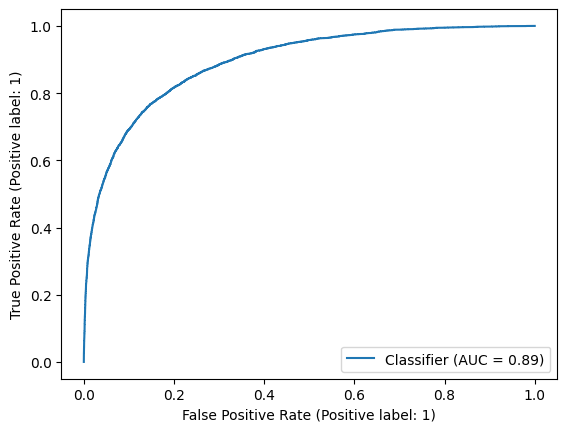

In [14]:
RocCurveDisplay.from_predictions(y_test,pred_proba)

In [15]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87     19518
           1       0.54      0.80      0.64      5238

    accuracy                           0.81     24756
   macro avg       0.74      0.81      0.76     24756
weighted avg       0.85      0.81      0.83     24756



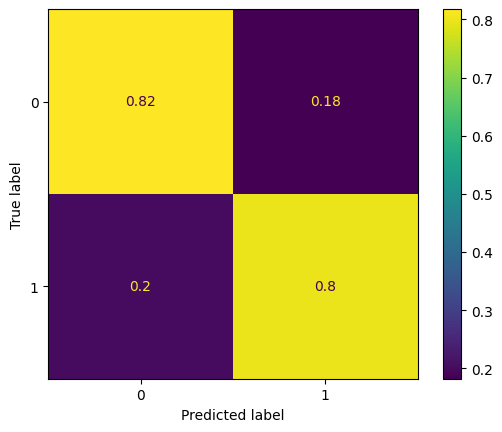

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred, normalize='true')).plot()

# Submission

In [17]:
X_val_scld = prepro.transform(test)

In [18]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [19]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [20]:
submission

,Exited
id,
165034,0.080412
165035,0.951204
165036,0.096977
165037,0.529652
165038,0.639720
...,...
275052,0.134360
275053,0.228869
275054,0.064918


In [21]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [23]:
#submission.to_csv(f"submission/{name}.csv")